## Vision - Image Analysis

In [ ]:
%env AZURE_COG_SERVICE_ENDPOINT=<AZURE_COG_SERVICE_ENDPOINT>
%env AZURE_COG_SERVICEE_KEY=<AZURE_COG_SERVICEE_KEY>

Analyzing input/images/street.jpg
Description: 'a person walking a dog on a street' (confidence: 45.83%)
Tags: 
 -'outdoor' (confidence: 99.87%)
 -'land vehicle' (confidence: 99.02%)
 -'vehicle' (confidence: 98.89%)
 -'building' (confidence: 98.55%)
 -'road' (confidence: 95.98%)
 -'wheel' (confidence: 95.14%)
 -'street' (confidence: 94.71%)
 -'person' (confidence: 93.01%)
 -'clothing' (confidence: 91.19%)
 -'taxi' (confidence: 90.95%)
 -'animal' (confidence: 90.44%)
 -'car' (confidence: 84.01%)
 -'dog' (confidence: 82.68%)
 -'yellow' (confidence: 77.08%)
 -'walking' (confidence: 74.11%)
 -'city' (confidence: 64.80%)
 -'woman' (confidence: 57.53%)
Categories:
 -'outdoor_' (confidence: 0.39%)
 -'outdoor_road' (confidence: 55.86%)
Objects in image:
 -car (confidence: 72.40%)
 -taxi (confidence: 77.00%)
 -person (confidence: 78.10%)
 -dog (confidence: 54.40%)
  Results saved in objects.jpg
Ratings:
 -Adult: False
 -Racy: False
 -Gore: False
Generating thumbnail
Thumbnail saved in. thumbnai

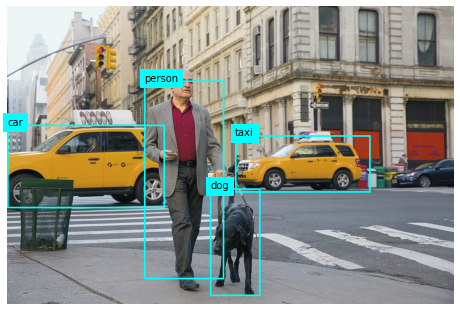

In [23]:
import os
from array import array
from PIL import Image, ImageDraw
import sys
import time
from matplotlib import pyplot as plt
import numpy as np

from azure.cognitiveservices.vision.computervision import ComputerVisionClient
from azure.cognitiveservices.vision.computervision.models import VisualFeatureTypes
from msrest.authentication import CognitiveServicesCredentials


def main():
    global cv_client

    try:
        # Get Configuration Settings
        #load_dotenv()

        cog_endpoint = os.environ["AZURE_COG_SERVICE_ENDPOINT"]
        cog_key = os.environ["AZURE_COG_SERVICEE_KEY"]

        # Get image
        image_file = 'input/images/street.jpg'
        #if len(sys.argv) > 1:
        #    image_file = sys.argv[1]

        # Authenticate Computer Vision client
        credential = CognitiveServicesCredentials(cog_key) 
        cv_client = ComputerVisionClient(cog_endpoint, credential)


         
        # Analyze image
        AnalyzeImage(image_file)

        
        # Generate thumbnail
        GetThumbnail(image_file)

    except Exception as ex:
        print(ex)

def AnalyzeImage(image_file):
    print('Analyzing', image_file)

    # Specify features to be retrieved
    features = [VisualFeatureTypes.description,
            VisualFeatureTypes.tags,
            VisualFeatureTypes.categories,
            VisualFeatureTypes.brands,
            VisualFeatureTypes.objects,
            VisualFeatureTypes.adult]
    
    with open(image_file, mode="rb") as image_data:
        analysis = cv_client.analyze_image_in_stream(image_data , features)
     
    # Get image description
    for caption in analysis.description.captions:
        print("Description: '{}' (confidence: {:.2f}%)".format(caption.text, caption.confidence * 100))

    # Get image tags
    if (len(analysis.tags) > 0):
        print("Tags: ")
        for tag in analysis.tags:
            print(" -'{}' (confidence: {:.2f}%)".format(tag.name, tag.confidence * 100))
    
    # Get image categories
    if (len(analysis.categories) > 0):
        print("Categories:")
        landmarks = []
        for category in analysis.categories:
            # Print the category
            print(" -'{}' (confidence: {:.2f}%)".format(category.name, category.score * 100))
            if category.detail:
                # Get landmarks in this category
                if category.detail.landmarks:
                    for landmark in category.detail.landmarks:
                        if landmark not in landmarks:
                            landmarks.append(landmark)

        # If there were landmarks, list them
        if len(landmarks) > 0:
            print("Landmarks:")
            for landmark in landmarks:
                print(" -'{}' (confidence: {:.2f}%)".format(landmark.name, landmark.confidence * 100))
    
    # Get brands in the image
    if (len(analysis.brands) > 0):
        print("Brands: ")
        for brand in analysis.brands:
            print(" -'{}' (confidence: {:.2f}%)".format(brand.name, brand.confidence * 100))



    # Get objects in the image
    if len(analysis.objects) > 0:
        print("Objects in image:")

        # Prepare image for drawing
        fig = plt.figure(figsize=(8, 8))
        plt.axis('off')
        image = Image.open(image_file)
        draw = ImageDraw.Draw(image)
        color = 'cyan'
        for detected_object in analysis.objects:
            # Print object name
            print(" -{} (confidence: {:.2f}%)".format(detected_object.object_property, detected_object.confidence * 100))
            
            # Draw object bounding box
            r = detected_object.rectangle
            bounding_box = ((r.x, r.y), (r.x + r.w, r.y + r.h))
            draw.rectangle(bounding_box, outline=color, width=3)
            plt.annotate(detected_object.object_property,(r.x, r.y), backgroundcolor=color)
        # Save annotated image
        plt.imshow(image)
        outputfile = 'objects.jpg'
        fig.savefig(outputfile)
        print('  Results saved in', outputfile)


    # Get moderation ratings
    ratings = 'Ratings:\n -Adult: {}\n -Racy: {}\n -Gore: {}'.format(analysis.adult.is_adult_content,
                                                                        analysis.adult.is_racy_content,
                                                                        analysis.adult.is_gory_content)
    print(ratings)


def GetThumbnail(image_file):
    print('Generating thumbnail')

    # Generate a thumbnail
    with open(image_file, mode="rb") as image_data:
        # Get thumbnail data
        thumbnail_stream = cv_client.generate_thumbnail_in_stream(100, 100, image_data, True)

    # Save thumbnail image
    thumbnail_file_name = 'thumbnail.png'
    with open(thumbnail_file_name, "wb") as thumbnail_file:
        for chunk in thumbnail_stream:
            thumbnail_file.write(chunk)

    print('Thumbnail saved in.', thumbnail_file_name)


if __name__ == "__main__":
    main()


## Vision - Image Classification - custom model

In [24]:
%env ProjectID=d3881424-a0a6-409b-ba39-757c6601f9a1

env: ProjectID=d3881424-a0a6-409b-ba39-757c6601f9a1


###   Image Classification - custom model training

In [25]:
from azure.cognitiveservices.vision.customvision.training import CustomVisionTrainingClient
from azure.cognitiveservices.vision.customvision.training.models import ImageFileCreateBatch, ImageFileCreateEntry, Region
from msrest.authentication import ApiKeyCredentials
import time
import os

def main():
    #from dotenv import load_dotenv
    global training_client
    global custom_vision_project

    try:
        # Get Configuration Settings
        #load_dotenv()
         
        training_endpoint = os.environ["AZURE_COG_SERVICE_ENDPOINT"]
        training_key = os.environ["AZURE_COG_SERVICEE_KEY"]

        project_id = os.environ['ProjectID']
        # Authenticate a client for the training API
        credentials = ApiKeyCredentials(in_headers={"Training-key": training_key})
        training_client = CustomVisionTrainingClient(training_endpoint, credentials)

        # Get the Custom Vision project
        custom_vision_project = training_client.get_project(project_id)

        # Upload and tag images
        #Upload_Images('more-training-images')

        # Train the model
        Train_Model()
        
    except Exception as ex:
        print(ex)

def Upload_Images(folder):
    print("Uploading images...")
    tags = training_client.get_tags(custom_vision_project.id)
    for tag in tags:
        print(tag.name)
        for image in os.listdir(os.path.join(folder,tag.name)):
            image_data = open(os.path.join(folder,tag.name,image), "rb").read()
            training_client.create_images_from_data(custom_vision_project.id, image_data, [tag.id])

def Train_Model():
    print("Training ...")
    iteration = training_client.train_project(custom_vision_project.id)
    while (iteration.status != "Completed"):
        iteration = training_client.get_iteration(custom_vision_project.id, iteration.id)
        print (iteration.status, '...')
        time.sleep(5)
    print ("Model trained!")


if __name__ == "__main__":
    main()




Training ...
Nothing changed since last training


###   Image Classification - custom model prediction

In [37]:
%env ProjectID=d3881424-a0a6-409b-ba39-757c6601f9a1
%env ModelName=Iteration2

env: ProjectID=d3881424-a0a6-409b-ba39-757c6601f9a1
env: ModelName=Iteration2


In [38]:
from azure.cognitiveservices.vision.customvision.prediction import CustomVisionPredictionClient
from msrest.authentication import ApiKeyCredentials
import os

def main():
    from dotenv import load_dotenv

    try:
        # Get Configuration Settings
        load_dotenv()
         
        prediction_endpoint = os.environ["AZURE_COG_SERVICE_ENDPOINT"] 
        prediction_key = os.environ["AZURE_COG_SERVICEE_KEY"]
        project_id = os.environ['ProjectID']
        model_name = os.getenv('ModelName')
        print(model_name)
        # Authenticate a client for the training API
        credentials = ApiKeyCredentials(in_headers={"Prediction-key": prediction_key})
        prediction_client = CustomVisionPredictionClient(endpoint=prediction_endpoint, credentials=credentials)

        # Classify test images
        test_image_path = 'input/images/custom_model_test'
        for image in os.listdir(test_image_path):
            if image.endswith(".jpg"):
                image_data = open(os.path.join(test_image_path,image), "rb").read()
                results = prediction_client.classify_image(project_id, model_name, image_data)

                # Loop over each label prediction and print any with probability > 50%
                for prediction in results.predictions:
                    if prediction.probability > 0.5:
                        print(image, ': {} ({:.0%})'.format(prediction.tag_name, prediction.probability))
    except Exception as ex:
        print(ex)

if __name__ == "__main__":
    main()


Iteration2
IMG_TEST_1.jpg : apple (100%)
IMG_TEST_2.jpg : banana (100%)
IMG_TEST_3.jpg : orange (100%)


###   Image Classification - Custom model training - Object Detection

Find project ID from the under setting of custom vision project

In [39]:
%env ProjectID=52a54e08-718e-43bc-8e25-02a4a8689d0e

env: ProjectID=52a54e08-718e-43bc-8e25-02a4a8689d0e


In [40]:
from azure.cognitiveservices.vision.customvision.training import CustomVisionTrainingClient
from azure.cognitiveservices.vision.customvision.training.models import ImageFileCreateBatch, ImageFileCreateEntry, Region
from msrest.authentication import ApiKeyCredentials
import time
import json
import os

def main():
    #from dotenv import load_dotenv
    global training_client
    global custom_vision_project

    try:
        # Get Configuration Settings
        #load_dotenv()
        training_endpoint = os.getenv('AZURE_COG_SERVICE_ENDPOINT')
        training_key = os.getenv('AZURE_COG_SERVICEE_KEY')
        project_id = os.getenv('ProjectID')

        # Authenticate a client for the training API
        credentials = ApiKeyCredentials(in_headers={"Training-key": training_key})
        training_client = CustomVisionTrainingClient(training_endpoint, credentials)

        # Get the Custom Vision project
        custom_vision_project = training_client.get_project(project_id)
        #print(custom_vision_project)
        # Upload and tag images
        #Upload_Images('input/images/object_detection_training/')

         # Train the model
        Train_Model()
    
    except Exception as ex:
        print(ex)



def Upload_Images(folder):
    print("Uploading images...")

    # Get the tags defined in the project
    tags = training_client.get_tags(custom_vision_project.id)

    # Create a list of images with tagged regions
    tagged_images_with_regions = []
     
    # Get the images and tagged regions from the JSON file
     
    with open(f"{folder}tagged-images.json", 'r') as json_file:
        tagged_images = json.load(json_file)
        #print(tagged_images)
        for image in tagged_images['files']:
            # Get the filename
            file = image['filename']
             
            # Get the tagged regions
            regions = []
            for tag in image['tags']:
                tag_name = tag['tag']
            
                # Look up the tag ID for this tag name
                tag_id = next(t for t in tags if t.name == tag_name).id
                 
                # Add a region for this tag using the coordinates and dimensions in the JSON
                regions.append(Region(tag_id=tag_id, left=tag['left'],top=tag['top'],width=tag['width'],height=tag['height']))
            
            # Add the image and its regions to the list
            with open(os.path.join(folder,file), mode="rb") as image_data:
                tagged_images_with_regions.append(ImageFileCreateEntry(name=file, contents=image_data.read(), regions=regions))

     
 
    # Upload the list of images as a batch
    upload_result = training_client.create_images_from_files(custom_vision_project.id, ImageFileCreateBatch(images=tagged_images_with_regions))
    # Check for failure
    if not upload_result.is_batch_successful:
        print("Image batch upload failed.")
        for image in upload_result.images:
            print("Image status: ", image.status)
    else:
        print("Images uploaded.")

def Train_Model():
    print("Training ...")
    iteration = training_client.train_project(custom_vision_project.id)
    while (iteration.status != "Completed"):
        iteration = training_client.get_iteration(custom_vision_project.id, iteration.id)
        print (iteration.status, '...')
        time.sleep(5)
    print ("Model trained!")


if __name__ == "__main__":
    main()

Training ...
Nothing changed since last training


###   Image Classification - Custom model testing - Object Detection

Need to get the model name after **publish** the trained model

In [41]:
%env ModelName=Iteration1

env: ModelName=Iteration1


Detecting objects in input/images/produce.jpg
Results saved in  output.jpg


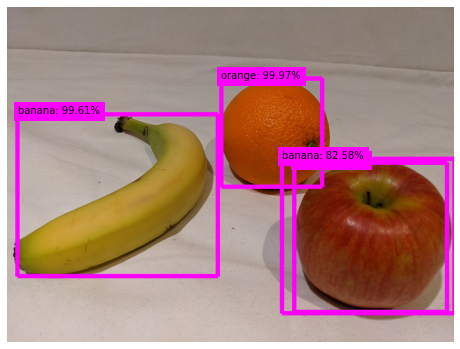

In [42]:
from azure.cognitiveservices.vision.customvision.prediction import CustomVisionPredictionClient
from msrest.authentication import ApiKeyCredentials
from matplotlib import pyplot as plt
from PIL import Image, ImageDraw, ImageFont
import numpy as np
import os

def main():
    #from dotenv import load_dotenv

    try:
        # Get Configuration Settings
        #load_dotenv()
         
        prediction_endpoint = os.getenv('AZURE_COG_SERVICE_ENDPOINT')
        
        prediction_key = os.getenv('AZURE_COG_SERVICEE_KEY')
         
        project_id = os.getenv('ProjectID')

        model_name = os.getenv('ModelName')

        # Authenticate a client for the training API
        credentials = ApiKeyCredentials(in_headers={"Prediction-key": prediction_key})
        prediction_client = CustomVisionPredictionClient(endpoint=prediction_endpoint, credentials=credentials)

        # Load image and get height, width and channels
        image_file = 'input/images/produce.jpg'
        print('Detecting objects in', image_file)
        image = Image.open(image_file)
        h, w, ch = np.array(image).shape

        # Detect objects in the test image
        with open(image_file, mode="rb") as image_data:
            results = prediction_client.detect_image(project_id, model_name, image_data)

        # Create a figure for the results
        fig = plt.figure(figsize=(8, 8))
        plt.axis('off')

        # Display the image with boxes around each detected object
        draw = ImageDraw.Draw(image)
        lineWidth = int(w/100)
        color = 'magenta'
        for prediction in results.predictions:
            # Only show objects with a > 50% probability
            if (prediction.probability*100) > 50:
                # Box coordinates and dimensions are proportional - convert to absolutes
                left = prediction.bounding_box.left * w 
                top = prediction.bounding_box.top * h 
                height = prediction.bounding_box.height * h
                width =  prediction.bounding_box.width * w
                # Draw the box
                points = ((left,top), (left+width,top), (left+width,top+height), (left,top+height),(left,top))
                draw.line(points, fill=color, width=lineWidth)
                # Add the tag name and probability
                plt.annotate(prediction.tag_name + ": {0:.2f}%".format(prediction.probability * 100),(left,top), backgroundcolor=color)
        plt.imshow(image)
        outputfile = 'output.jpg'
        fig.savefig(outputfile)
        print('Results saved in ', outputfile)
    except Exception as ex:
        print(ex)

if __name__ == "__main__":
    main()


###   Image Classification - Face Analysis

Analyzing input/images/people.jpg
2 faces detected.
Results saved in detected_faces.jpg


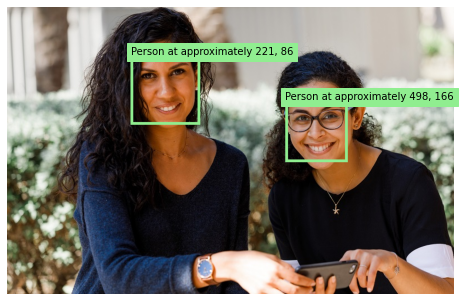

In [34]:
import os
from PIL import Image, ImageDraw
from matplotlib import pyplot as plt

from azure.cognitiveservices.vision.computervision import ComputerVisionClient
from azure.cognitiveservices.vision.computervision.models import VisualFeatureTypes
from msrest.authentication import CognitiveServicesCredentials


def main():

    global cv_client

    try:
        # Get Configuration Settings
         
         
        cog_endpoint = os.getenv('AZURE_COG_SERVICE_ENDPOINT')
        cog_key = os.getenv('AZURE_COG_SERVICEE_KEY')

        # Authenticate Computer Vision client
        credential = CognitiveServicesCredentials(cog_key) 
        cv_client = ComputerVisionClient(cog_endpoint, credential)
        # Detect faces in an image
        image_file = os.path.join('input/images','people.jpg')
        AnalyzeFaces(image_file)

    except Exception as ex:
        print(ex)

def AnalyzeFaces(image_file):
    print('Analyzing', image_file)

    # Specify features to be retrieved (faces)
    features = [VisualFeatureTypes.faces]


    # Get image analysis
    with open(image_file, mode="rb") as image_data:
        analysis = cv_client.analyze_image_in_stream(image_data , features)

        # Get faces
        if analysis.faces:
            print(len(analysis.faces), 'faces detected.')

            # Prepare image for drawing
            fig = plt.figure(figsize=(8, 6))
            plt.axis('off')
            image = Image.open(image_file)
            draw = ImageDraw.Draw(image)
            color = 'lightgreen'

            # Draw and annotate each face
            for face in analysis.faces:
                r = face.face_rectangle
                bounding_box = ((r.left, r.top), (r.left + r.width, r.top + r.height))
                draw = ImageDraw.Draw(image)
                draw.rectangle(bounding_box, outline=color, width=5)
                annotation = 'Person at approximately {}, {}'.format(r.left, r.top)
                plt.annotate(annotation,(r.left, r.top), backgroundcolor=color)

            # Save annotated image
            plt.imshow(image)
            outputfile = 'detected_faces.jpg'
            fig.savefig(outputfile)

            print('Results saved in', outputfile)



if __name__ == "__main__":
    main()

###   Image Classification - Read Text

In [35]:
from dotenv import load_dotenv
import os
import time
from PIL import Image, ImageDraw
from matplotlib import pyplot as plt

from azure.cognitiveservices.vision.computervision import ComputerVisionClient
from azure.cognitiveservices.vision.computervision.models import OperationStatusCodes
from msrest.authentication import CognitiveServicesCredentials


def main():

    global cv_client

    try:
        # Get Configuration Settings
         
        cog_endpoint = os.getenv('AZURE_COG_SERVICE_ENDPOINT')
        cog_key = os.getenv('AZURE_COG_SERVICEE_KEY')

        # Authenticate Computer Vision client
        credential = CognitiveServicesCredentials(cog_key) 
        cv_client = ComputerVisionClient(cog_endpoint, credential)

        path = 'input/images/read_text/' 

        # Menu for text reading functions
        print('1: Use OCR API\n2: Use Read API\n3: Read handwriting\nAny other key to quit')
        command = input('Enter a number:')
        if command == '1':
            image_file = os.path.join(path,'Lincoln.jpg')
            GetTextRead(image_file)
        elif command =='2':
            image_file = os.path.join(path,'Rome.pdf')
            GetTextRead(image_file)
        elif command =='3':
            image_file = os.path.join(path,'Note.jpg')
            GetTextRead(image_file)
                

    except Exception as ex:
        print(ex)

def GetTextRead(image_file):
    print('Reading text in {}\n'.format(image_file))
    # Use Read API to read text in image
    with open(image_file, mode="rb") as image_data:
        read_op = cv_client.read_in_stream(image_data, raw=True)

        # Get the async operation ID so we can check for the results
        operation_location = read_op.headers["Operation-Location"]
        operation_id = operation_location.split("/")[-1]

        # Wait for the asynchronous operation to complete
        while True:
            read_results = cv_client.get_read_result(operation_id)
            if read_results.status not in [OperationStatusCodes.running, OperationStatusCodes.not_started]:
                break
            time.sleep(1)

        # If the operation was successfully, process the text line by line
        if read_results.status == OperationStatusCodes.succeeded:
            for page in read_results.analyze_result.read_results:
                for line in page.lines:
                    print(line.text)
                    print(line.bounding_box)




if __name__ == "__main__":
    main()

1: Use OCR API
2: Use Read API
3: Read handwriting
Any other key to quit
Reading text in input/images/read_text/Lincoln.jpg

IN THIS TEMPLE
[325.0, 171.0, 478.0, 169.0, 478.0, 184.0, 325.0, 186.0]
AS IN THE HEARTS OF THE PEOPLE
[241.0, 194.0, 563.0, 187.0, 564.0, 204.0, 241.0, 210.0]
FOR WHOM HE SAVED THE UNION
[237.0, 214.0, 567.0, 209.0, 568.0, 224.0, 237.0, 230.0]
THE MEMORY OF ABRAHAM LINCOLN
[226.0, 235.0, 577.0, 229.0, 577.0, 246.0, 226.0, 253.0]
IS ENSHRINED FOREVER
[287.0, 255.0, 516.0, 252.0, 516.0, 268.0, 287.0, 272.0]
